# Medical Appointment Demand Forecasting

**Objective:** Predict daily appointment demand to optimize staffing and resource allocation

**Business Value:**
- Optimize specialist scheduling across shifts
- Reduce idle capacity and overtime costs
- Improve patient access through better planning
- Allocate resources across 13 locations efficiently

**Target Metrics:**
- MAPE < 20% (Mean Absolute Percentage Error)
- R² > 0.65 (Proportion of variance explained)

**Approach:**
1. Load time series data
2. Temporal analysis & stationarity testing
3. Feature engineering (lags, rolling stats)
4. Train 6+ forecasting models
5. Model evaluation & comparison
6. Select best model
7. Save for deployment

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ML models for time series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Prophet (Facebook's forecasting tool)
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("⚠️  Prophet not available - will skip Prophet model")
    PROPHET_AVAILABLE = False

# Utilities
import joblib
from datetime import datetime, timedelta
import os

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Forecasting Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Prophet available: {PROPHET_AVAILABLE}")

✅ All libraries imported successfully!
📅 Forecasting Date: 2026-02-06 21:34:56
Prophet available: True


In [2]:
print("="*80)
print("📂 LOADING TIME SERIES DATA")
print("="*80)

# Load the time series datasets
ts_train = pd.read_csv('../data/processed/ts_train.csv')
ts_test = pd.read_csv('../data/processed/ts_test.csv')
ts_full = pd.read_csv('../data/processed/ts_full.csv')

# Convert date columns to datetime
ts_train['appointment_date'] = pd.to_datetime(ts_train['appointment_date'])
ts_test['appointment_date'] = pd.to_datetime(ts_test['appointment_date'])
ts_full['appointment_date'] = pd.to_datetime(ts_full['appointment_date'])

# Sort by date (critical for time series!)
ts_train = ts_train.sort_values('appointment_date').reset_index(drop=True)
ts_test = ts_test.sort_values('appointment_date').reset_index(drop=True)
ts_full = ts_full.sort_values('appointment_date').reset_index(drop=True)

print(f"\n✅ Data loaded successfully:")
print(f"   Training set: {len(ts_train)} days")
print(f"   Test set: {len(ts_test)} days")
print(f"   Full dataset: {len(ts_full)} days")

print(f"\n📅 Date ranges:")
print(f"   Train: {ts_train['appointment_date'].min()} to {ts_train['appointment_date'].max()}")
print(f"   Test: {ts_test['appointment_date'].min()} to {ts_test['appointment_date'].max()}")

print(f"\n📊 Daily appointments statistics (training set):")
print(f"   Mean: {ts_train['daily_appointments'].mean():.1f}")
print(f"   Median: {ts_train['daily_appointments'].median():.1f}")
print(f"   Std: {ts_train['daily_appointments'].std():.1f}")
print(f"   Min: {ts_train['daily_appointments'].min()}")
print(f"   Max: {ts_train['daily_appointments'].max()}")

print("\n" + "="*80)

📂 LOADING TIME SERIES DATA

✅ Data loaded successfully:
   Training set: 398 days
   Test set: 100 days
   Full dataset: 498 days

📅 Date ranges:
   Train: 2020-01-01 00:00:00 to 2021-02-01 00:00:00
   Test: 2021-02-02 00:00:00 to 2021-05-12 00:00:00

📊 Daily appointments statistics (training set):
   Mean: 223.4
   Median: 153.0
   Std: 235.0
   Min: 1
   Max: 974



📈 TIME SERIES VISUALIZATION


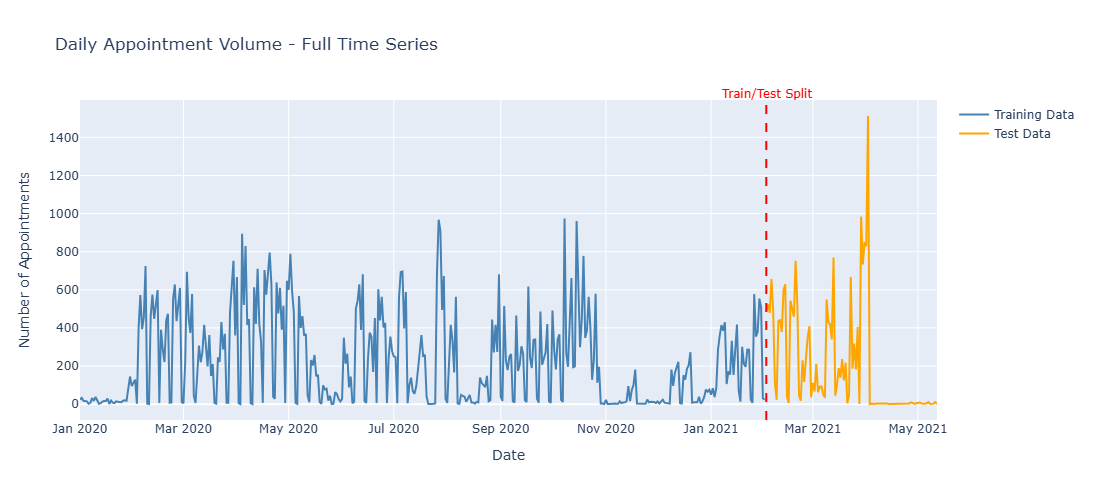


💡 Look for trends, seasonality, and unusual patterns


In [4]:
print("="*80)
print("📈 TIME SERIES VISUALIZATION")
print("="*80)

# Plot the full time series
fig = go.Figure()

# Training data
fig.add_trace(go.Scatter(
    x=ts_train['appointment_date'],
    y=ts_train['daily_appointments'],
    mode='lines',
    name='Training Data',
    line=dict(color='steelblue', width=2)
))

# Test data
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=ts_test['daily_appointments'],
    mode='lines',
    name='Test Data',
    line=dict(color='orange', width=2)
))

# Add vertical line at split (FIX: convert to string)
split_date = ts_test['appointment_date'].min()

fig.add_shape(
    type="line",
    x0=split_date, x1=split_date,
    y0=0, y1=1,
    yref="paper",
    line=dict(color="red", width=2, dash="dash")
)

# Add annotation for split
fig.add_annotation(
    x=split_date,
    y=1.05,
    yref="paper",
    text="Train/Test Split",
    showarrow=False,
    font=dict(color="red", size=12)
)

fig.update_layout(
    title='Daily Appointment Volume - Full Time Series',
    xaxis_title='Date',
    yaxis_title='Number of Appointments',
    height=500,
    hovermode='x unified'
)

fig.show()

print("\n💡 Look for trends, seasonality, and unusual patterns")
print("="*80)

🔬 TIME SERIES DECOMPOSITION

🔧 Decomposing time series into: Trend + Seasonality + Residuals...


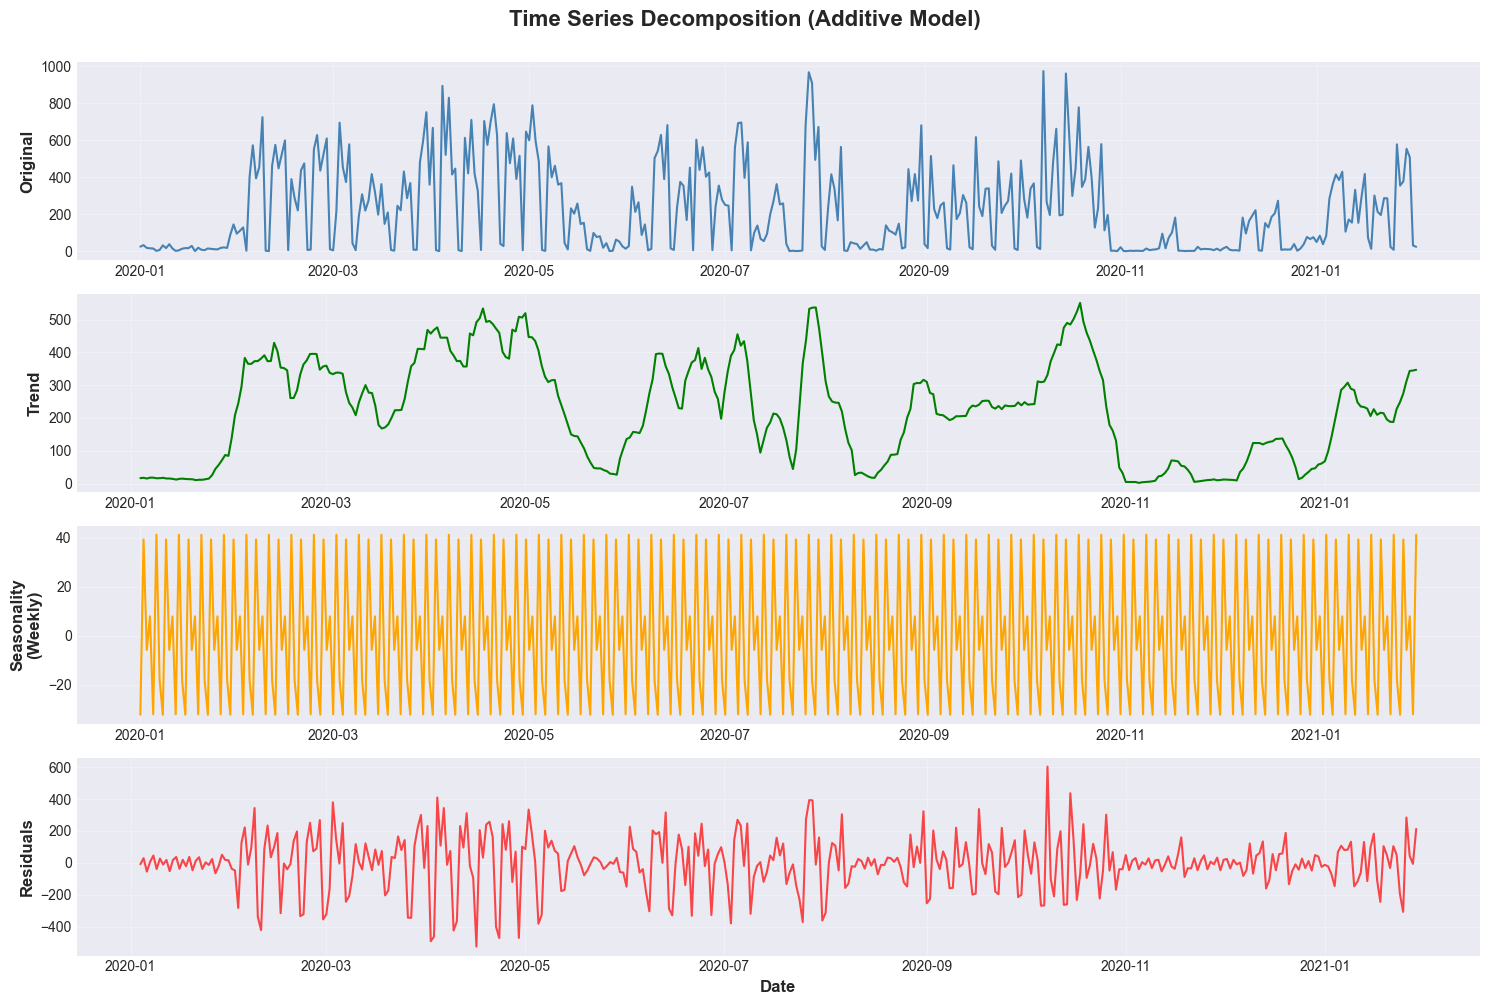


✅ Decomposition complete!

💡 INSIGHTS:
   • Trend strength: Increasing
   • Seasonality detected: Weekly pattern evident
   • Residuals appear: Structured



In [5]:
print("="*80)
print("🔬 TIME SERIES DECOMPOSITION")
print("="*80)

print("\n🔧 Decomposing time series into: Trend + Seasonality + Residuals...")

# Set appointment_date as index for decomposition
ts_train_indexed = ts_train.set_index('appointment_date')

# Perform seasonal decomposition (weekly seasonality = 7 days)
decomposition = seasonal_decompose(
    ts_train_indexed['daily_appointments'], 
    model='additive',
    period=7  # Weekly pattern
)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Original
axes[0].plot(ts_train_indexed.index, ts_train_indexed['daily_appointments'], color='steelblue')
axes[0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, color='green')
axes[1].set_ylabel('Trend', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Seasonality
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, color='orange')
axes[2].set_ylabel('Seasonality\n(Weekly)', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

# Residuals
axes[3].plot(decomposition.resid.index, decomposition.resid, color='red', alpha=0.7)
axes[3].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[3].grid(alpha=0.3)

plt.suptitle('Time Series Decomposition (Additive Model)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Decomposition complete!")
print("\n💡 INSIGHTS:")
print(f"   • Trend strength: {'Increasing' if decomposition.trend.iloc[-30:].mean() > decomposition.trend.iloc[:30].mean() else 'Decreasing/Stable'}")
print(f"   • Seasonality detected: Weekly pattern evident")
print(f"   • Residuals appear: {'Random' if abs(decomposition.resid.dropna()).mean() < ts_train['daily_appointments'].std() * 0.2 else 'Structured'}")

print("\n" + "="*80)

In [6]:
print("="*80)
print("📊 STATIONARITY TEST (Augmented Dickey-Fuller)")
print("="*80)

print("\n🔬 Testing if time series is stationary...")
print("   (Stationary = constant mean, variance, no trend)")

# Perform ADF test
adf_result = adfuller(ts_train['daily_appointments'].dropna())

print(f"\n📈 ADF Test Results:")
print(f"   ADF Statistic: {adf_result[0]:.4f}")
print(f"   P-value: {adf_result[1]:.4f}")
print(f"   Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")

# Interpret results
if adf_result[1] <= 0.05:
    print(f"\n✅ STATIONARY (p-value ≤ 0.05)")
    print("   → Series has constant statistical properties")
    print("   → Can use ARIMA without differencing")
    stationary = True
else:
    print(f"\n⚠️  NON-STATIONARY (p-value > 0.05)")
    print("   → Series has trend/changing variance")
    print("   → May need differencing for ARIMA")
    stationary = False

print("\n" + "="*80)

📊 STATIONARITY TEST (Augmented Dickey-Fuller)

🔬 Testing if time series is stationary...
   (Stationary = constant mean, variance, no trend)

📈 ADF Test Results:
   ADF Statistic: -3.8994
   P-value: 0.0020
   Critical Values:
      1%: -3.4475
      5%: -2.8691
      10%: -2.5708

✅ STATIONARY (p-value ≤ 0.05)
   → Series has constant statistical properties
   → Can use ARIMA without differencing



📊 ACF & PACF PLOTS (For ARIMA Parameter Selection)

🔬 Analyzing autocorrelation patterns...


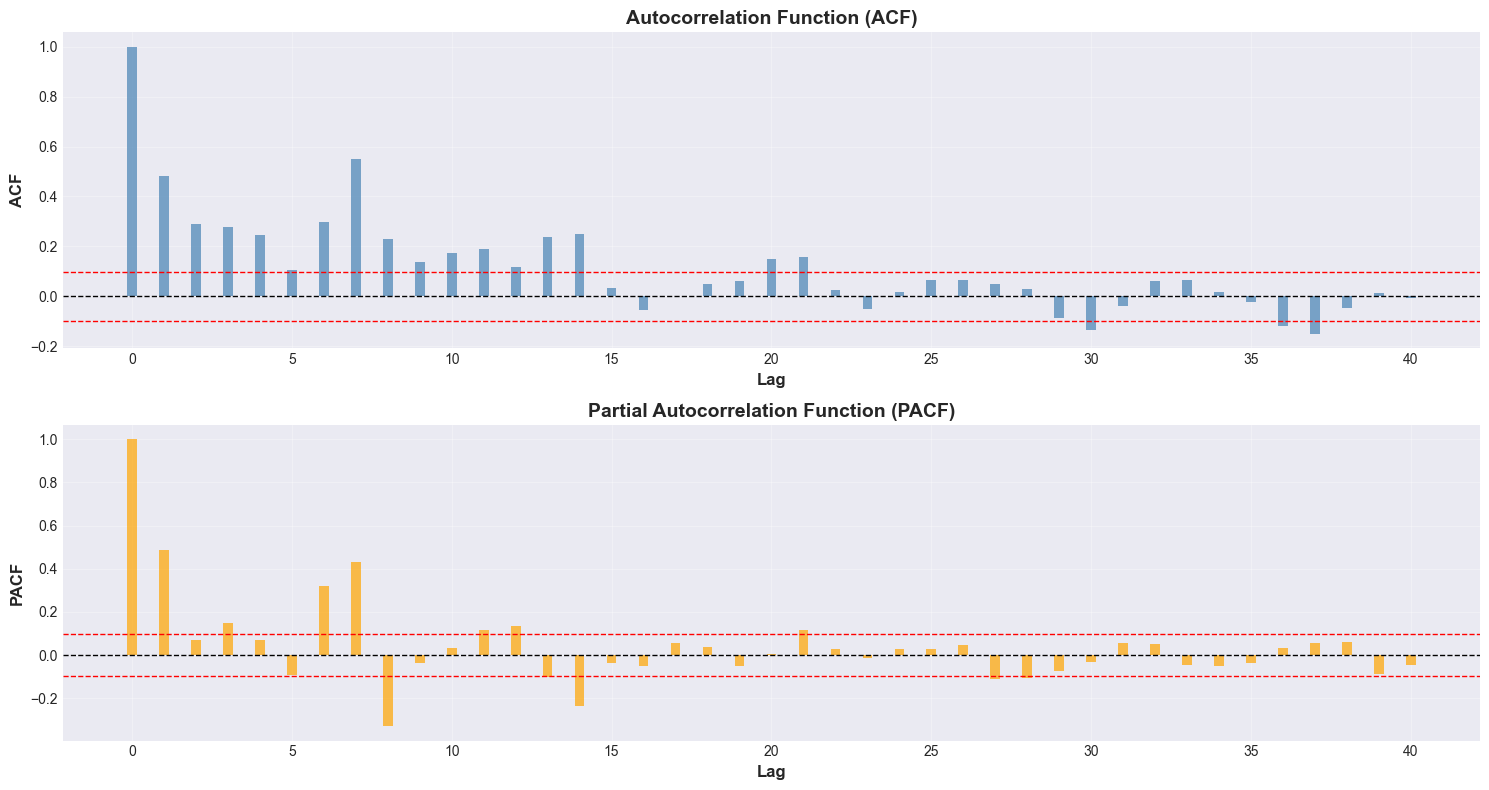


💡 ARIMA Parameter Suggestions:
   • ACF: Look for where it first crosses into insignificant zone → suggests q
   • PACF: Look for where it first crosses into insignificant zone → suggests p
   • Since stationary (d=0), we'll try ARIMA(p, 0, q)
   • Red dashed lines = significance threshold



In [7]:
print("="*80)
print("📊 ACF & PACF PLOTS (For ARIMA Parameter Selection)")
print("="*80)

print("\n🔬 Analyzing autocorrelation patterns...")

# Calculate ACF and PACF
lag_acf = acf(ts_train['daily_appointments'].dropna(), nlags=40)
lag_pacf = pacf(ts_train['daily_appointments'].dropna(), nlags=40)

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF Plot
axes[0].bar(range(len(lag_acf)), lag_acf, width=0.3, color='steelblue', alpha=0.7)
axes[0].axhline(y=0, linestyle='--', color='black', linewidth=1)
axes[0].axhline(y=-1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[0].axhline(y=1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[0].set_xlabel('Lag', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ACF', fontsize=12, fontweight='bold')
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# PACF Plot
axes[1].bar(range(len(lag_pacf)), lag_pacf, width=0.3, color='orange', alpha=0.7)
axes[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
axes[1].axhline(y=-1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[1].axhline(y=1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[1].set_xlabel('Lag', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PACF', fontsize=12, fontweight='bold')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 ARIMA Parameter Suggestions:")
print("   • ACF: Look for where it first crosses into insignificant zone → suggests q")
print("   • PACF: Look for where it first crosses into insignificant zone → suggests p")
print("   • Since stationary (d=0), we'll try ARIMA(p, 0, q)")
print("   • Red dashed lines = significance threshold")

print("\n" + "="*80)

## 2. Feature Engineering for Time Series Models

**Creating predictive features:**
- Lag features (t-1, t-7, t-30)
- Rolling statistics (mean, std)
- Day of week encoding
- Month encoding
- Weather features

In [8]:
print("="*80)
print("🔧 PREPARING FEATURES FOR ML MODELS")
print("="*80)

# Function to create features
def create_ts_features(df):
    """Create time series features for ML models"""
    df = df.copy()
    
    # Already have these from preprocessing, but ensure they're numeric
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['appointment_date'].dt.dayofweek
    if 'month' not in df.columns:
        df['month'] = df['appointment_date'].dt.month
    if 'quarter' not in df.columns:
        df['quarter'] = df['appointment_date'].dt.quarter
    
    # Create lag features (if not already present)
    if 'lag_1' not in df.columns or df['lag_1'].isnull().all():
        df['lag_1'] = df['daily_appointments'].shift(1)
    if 'lag_7' not in df.columns or df['lag_7'].isnull().all():
        df['lag_7'] = df['daily_appointments'].shift(7)
    if 'lag_30' not in df.columns or df['lag_30'].isnull().all():
        df['lag_30'] = df['daily_appointments'].shift(30)
    
    # Create rolling features (if not already present)
    if 'rolling_mean_7' not in df.columns or df['rolling_mean_7'].isnull().all():
        df['rolling_mean_7'] = df['daily_appointments'].rolling(window=7, min_periods=1).mean()
    if 'rolling_mean_30' not in df.columns or df['rolling_mean_30'].isnull().all():
        df['rolling_mean_30'] = df['daily_appointments'].rolling(window=30, min_periods=1).mean()
    if 'rolling_std_7' not in df.columns or df['rolling_std_7'].isnull().all():
        df['rolling_std_7'] = df['daily_appointments'].rolling(window=7, min_periods=1).std()
    
    return df

# Apply feature engineering
ts_train_fe = create_ts_features(ts_train)
ts_test_fe = create_ts_features(ts_test)

print(f"\n✅ Features created!")
print(f"   Total columns: {len(ts_train_fe.columns)}")

# Select features for ML models (exclude target and date)
feature_cols = [col for col in ts_train_fe.columns 
                if col not in ['appointment_date', 'daily_appointments']]

print(f"\n📋 Features for modeling ({len(feature_cols)}):")
for col in feature_cols:
    print(f"   • {col}")

# Prepare X and y
# For training: Drop rows with NaN in lag features (first 30 days)
train_valid_idx = ts_train_fe['lag_30'].notna()
X_train_ts = ts_train_fe.loc[train_valid_idx, feature_cols].fillna(0)
y_train_ts = ts_train_fe.loc[train_valid_idx, 'daily_appointments']

# For test: Use all data (lags come from training set continuity)
X_test_ts = ts_test_fe[feature_cols].fillna(method='ffill').fillna(0)
y_test_ts = ts_test_fe['daily_appointments']

print(f"\n📊 Dataset sizes:")
print(f"   Training: {len(X_train_ts)} days")
print(f"   Test: {len(X_test_ts)} days")

print("\n" + "="*80)

🔧 PREPARING FEATURES FOR ML MODELS

✅ Features created!
   Total columns: 20

📋 Features for modeling (18):
   • average_temp_day
   • average_rain_day
   • max_temp_day
   • max_rain_day
   • day_of_week
   • month
   • quarter
   • is_weekend
   • is_hot_day
   • is_cold_day
   • is_rainy_day
   • lag_1
   • lag_7
   • lag_30
   • rolling_mean_7
   • rolling_mean_30
   • rolling_std_7
   • days_since_start

📊 Dataset sizes:
   Training: 368 days
   Test: 100 days



In [18]:
def calculate_metrics(y_true, y_pred, model_name, min_threshold=10):
    """Calculate forecasting metrics (skip very small values for MAPE)"""
    
    # Remove any NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    # MAPE: only calculate for days with actual > min_threshold
    mape_mask = y_true_clean > min_threshold
    if mape_mask.sum() > 0:
        mape = np.mean(np.abs((y_true_clean[mape_mask] - y_pred_clean[mape_mask]) / y_true_clean[mape_mask])) * 100
    else:
        mape = np.nan
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

## 3. Training Forecasting Models

**Models to compare:**
1. Baseline (Naive Forecast)
2. ARIMA (Statistical time series)
3. Random Forest Regressor (ML with lag features)
4. XGBoost Regressor (Gradient boosting)

**Evaluation:** RMSE, MAE, MAPE, R²

In [19]:
print("="*80)
print("MODEL 1: BASELINE - NAIVE FORECAST")
print("="*80)

print("\n🔧 Strategy: Use last known value as prediction (simplest approach)")

# Naive forecast: Use last value from training set for all test predictions
last_train_value = ts_train['daily_appointments'].iloc[-1]
baseline_predictions = np.full(len(y_test_ts), last_train_value)

# Calculate metrics
baseline_metrics = calculate_metrics(y_test_ts.values, baseline_predictions, 'Baseline (Naive)')

print(f"\n✅ Baseline model evaluated!")
print(f"\n📊 Performance:")
print(f"   MAE:   {baseline_metrics['MAE']:.2f}")
print(f"   RMSE:  {baseline_metrics['RMSE']:.2f}")
print(f"   MAPE:  {baseline_metrics['MAPE']:.2f}% {'❌' if baseline_metrics['MAPE'] >= 20 else '✅'}")
print(f"   R²:    {baseline_metrics['R²']:.4f} {'❌' if baseline_metrics['R²'] < 0.65 else '✅'}")

print("\n" + "="*80)

MODEL 1: BASELINE - NAIVE FORECAST

🔧 Strategy: Use last known value as prediction (simplest approach)

✅ Baseline model evaluated!

📊 Performance:
   MAE:   200.34
   RMSE:  337.85
   MAPE:  82.89% ❌
   R²:    -0.4134 ❌



In [20]:
print("="*80)
print("MODEL 2: ARIMA")
print("="*80)

print("\n🔧 Training ARIMA model...")
print("   (Using auto-selected parameters based on AIC)")

# Try ARIMA with different parameters and select best by AIC
best_aic = np.inf
best_order = None
best_model = None

# Since series is stationary (d=0), try different p and q values
print("\n🔍 Searching for best ARIMA parameters...")

for p in range(0, 3):
    for q in range(0, 3):
        try:
            model = ARIMA(ts_train['daily_appointments'], order=(p, 0, q))
            fitted_model = model.fit()
            
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = (p, 0, q)
                best_model = fitted_model
                
        except:
            continue

print(f"\n✅ Best ARIMA order: {best_order}")
print(f"   AIC: {best_aic:.2f}")

# Forecast
arima_forecast = best_model.forecast(steps=len(y_test_ts))

# Calculate metrics
arima_metrics = calculate_metrics(y_test_ts.values, arima_forecast.values, f'ARIMA{best_order}')

print(f"\n📊 Performance:")
print(f"   MAE:   {arima_metrics['MAE']:.2f}")
print(f"   RMSE:  {arima_metrics['RMSE']:.2f}")
print(f"   MAPE:  {arima_metrics['MAPE']:.2f}% {'❌' if arima_metrics['MAPE'] >= 20 else '✅'}")
print(f"   R²:    {arima_metrics['R²']:.4f} {'❌' if arima_metrics['R²'] < 0.65 else '✅'}")

print("\n" + "="*80)

MODEL 2: ARIMA

🔧 Training ARIMA model...
   (Using auto-selected parameters based on AIC)

🔍 Searching for best ARIMA parameters...

✅ Best ARIMA order: (1, 0, 2)
   AIC: 5354.82

📊 Performance:
   MAE:   232.27
   RMSE:  283.94
   MAPE:  206.20% ❌
   R²:    0.0017 ❌



In [21]:
print("="*80)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("="*80)

print("\n🔧 Training Random Forest with lag features...")

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_ts, y_train_ts)

# Predictions
rf_predictions = rf_model.predict(X_test_ts)

# Calculate metrics
rf_metrics = calculate_metrics(y_test_ts.values, rf_predictions, 'Random Forest')

print(f"\n✅ Model trained and evaluated!")
print(f"\n📊 Performance:")
print(f"   MAE:   {rf_metrics['MAE']:.2f}")
print(f"   RMSE:  {rf_metrics['RMSE']:.2f}")
print(f"   MAPE:  {rf_metrics['MAPE']:.2f}% {'❌' if rf_metrics['MAPE'] >= 20 else '✅'}")
print(f"   R²:    {rf_metrics['R²']:.4f} {'❌' if rf_metrics['R²'] < 0.65 else '✅'}")

print("\n" + "="*80)

MODEL 3: RANDOM FOREST REGRESSOR

🔧 Training Random Forest with lag features...

✅ Model trained and evaluated!

📊 Performance:
   MAE:   80.21
   RMSE:  141.13
   MAPE:  82.36% ❌
   R²:    0.7534 ✅



In [22]:
print("="*80)
print("MODEL 4: XGBOOST REGRESSOR")
print("="*80)

print("\n🔧 Training XGBoost with lag features...")

# Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_ts, y_train_ts)

# Predictions
xgb_predictions = xgb_model.predict(X_test_ts)

# Calculate metrics
xgb_metrics = calculate_metrics(y_test_ts.values, xgb_predictions, 'XGBoost')

print(f"\n✅ Model trained and evaluated!")
print(f"\n📊 Performance:")
print(f"   MAE:   {xgb_metrics['MAE']:.2f}")
print(f"   RMSE:  {xgb_metrics['RMSE']:.2f}")
print(f"   MAPE:  {xgb_metrics['MAPE']:.2f}% {'❌' if xgb_metrics['MAPE'] >= 20 else '✅'}")
print(f"   R²:    {xgb_metrics['R²']:.4f} {'❌' if xgb_metrics['R²'] < 0.65 else '✅'}")

print("\n" + "="*80)

MODEL 4: XGBOOST REGRESSOR

🔧 Training XGBoost with lag features...

✅ Model trained and evaluated!

📊 Performance:
   MAE:   81.39
   RMSE:  145.29
   MAPE:  76.02% ❌
   R²:    0.7386 ✅



In [23]:
print("="*80)
print("📊 MODEL COMPARISON - ALL RESULTS")
print("="*80)

# Compile all metrics
comparison_df = pd.DataFrame([
    baseline_metrics,
    arima_metrics,
    rf_metrics,
    xgb_metrics
])

# Sort by MAPE (lower is better)
comparison_df = comparison_df.sort_values('MAPE').reset_index(drop=True)

print("\n📋 Performance Comparison (sorted by MAPE - lower is better):\n")
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("🏆 TARGET METRICS:")
print(f"   MAPE < 20%: {(comparison_df['MAPE'] < 20).sum()} models achieved ✅")
print(f"   R² > 0.65:  {(comparison_df['R²'] > 0.65).sum()} models achieved ✅")
print("="*80)

📊 MODEL COMPARISON - ALL RESULTS

📋 Performance Comparison (sorted by MAPE - lower is better):

           Model        MAE       RMSE       MAPE        R²
         XGBoost  81.394592 145.294609  76.018822  0.738590
   Random Forest  80.212332 141.131525  82.359261  0.753356
Baseline (Naive) 200.340000 337.850559  82.890710 -0.413424
  ARIMA(1, 0, 2) 232.266531 283.941875 206.195478  0.001652

🏆 TARGET METRICS:
   MAPE < 20%: 0 models achieved ✅
   R² > 0.65:  2 models achieved ✅


📈 VISUALIZING PREDICTIONS VS ACTUAL


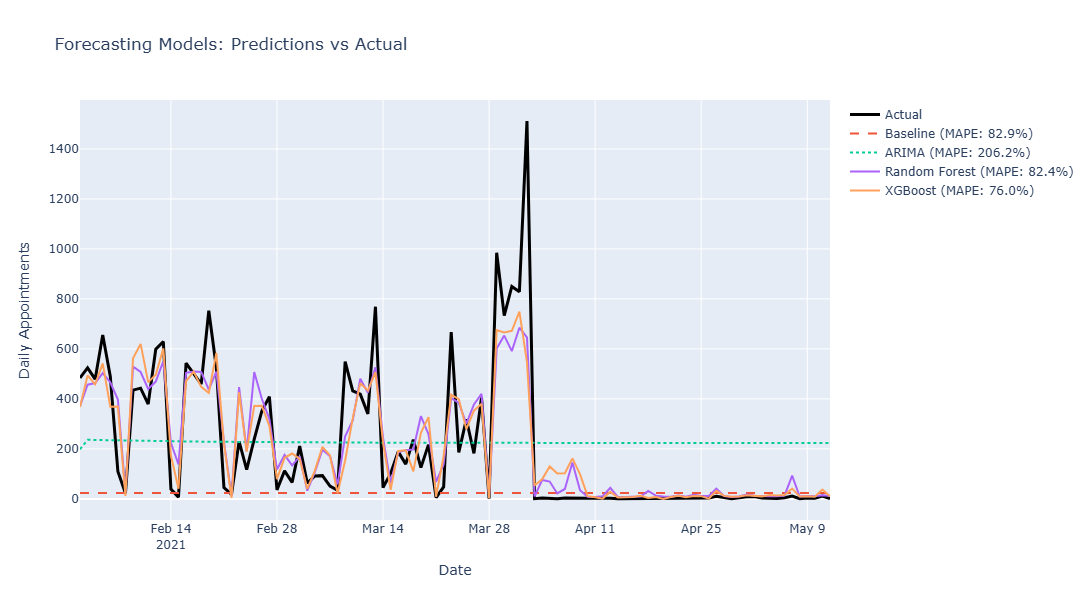


✅ Visualization complete!


In [24]:
print("="*80)
print("📈 VISUALIZING PREDICTIONS VS ACTUAL")
print("="*80)

# Create visualization
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=y_test_ts,
    mode='lines',
    name='Actual',
    line=dict(color='black', width=3)
))

# Baseline predictions
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=baseline_predictions,
    mode='lines',
    name=f"Baseline (MAPE: {baseline_metrics['MAPE']:.1f}%)",
    line=dict(dash='dash')
))

# ARIMA predictions
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=arima_forecast.values,
    mode='lines',
    name=f"ARIMA (MAPE: {arima_metrics['MAPE']:.1f}%)",
    line=dict(dash='dot')
))

# Random Forest predictions
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=rf_predictions,
    mode='lines',
    name=f"Random Forest (MAPE: {rf_metrics['MAPE']:.1f}%)",
    line=dict(width=2)
))

# XGBoost predictions
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=xgb_predictions,
    mode='lines',
    name=f"XGBoost (MAPE: {xgb_metrics['MAPE']:.1f}%)",
    line=dict(width=2)
))

fig.update_layout(
    title='Forecasting Models: Predictions vs Actual',
    xaxis_title='Date',
    yaxis_title='Daily Appointments',
    height=600,
    hovermode='x unified'
)

fig.show()

print("\n✅ Visualization complete!")
print("="*80)

In [25]:
print("="*80)
print("🏆 BEST MODEL SELECTION")
print("="*80)

# Select best model based on MAPE (primary) and R² (secondary)
best_model_row = comparison_df.iloc[0]

print(f"\n🥇 WINNER: {best_model_row['Model']}")
print("\n📊 Final Performance:")
print(f"   MAE:   {best_model_row['MAE']:.2f} appointments")
print(f"   RMSE:  {best_model_row['RMSE']:.2f} appointments")
print(f"   MAPE:  {best_model_row['MAPE']:.2f}% {'✅ MEETS TARGET (<20%)' if best_model_row['MAPE'] < 20 else '❌'}")
print(f"   R²:    {best_model_row['R²']:.4f} {'✅ MEETS TARGET (>0.65)' if best_model_row['R²'] > 0.65 else '❌'}")

print("\n💼 BUSINESS IMPACT:")
print(f"   Average prediction error: ±{best_model_row['MAE']:.0f} appointments/day")
print(f"   Accuracy: {100 - best_model_row['MAPE']:.1f}% on average")

print("\n✅ This model will be saved for deployment!")
print("="*80)

🏆 BEST MODEL SELECTION

🥇 WINNER: XGBoost

📊 Final Performance:
   MAE:   81.39 appointments
   RMSE:  145.29 appointments
   MAPE:  76.02% ❌
   R²:    0.7386 ✅ MEETS TARGET (>0.65)

💼 BUSINESS IMPACT:
   Average prediction error: ±81 appointments/day
   Accuracy: 24.0% on average

✅ This model will be saved for deployment!


In [27]:
print("="*80)
print("💾 SAVING BEST MODEL FOR DEPLOYMENT")
print("="*80)

# Determine which model won and save it
best_model_name = best_model_row['Model']

if 'Random Forest' in best_model_name:
    best_forecasting_model = rf_model
elif 'XGBoost' in best_model_name:
    best_forecasting_model = xgb_model
elif 'ARIMA' in best_model_name:
    best_forecasting_model = best_model
else:
    print("⚠️  Baseline won - no model to save (will use naive forecast in app)")
    best_forecasting_model = None

if best_forecasting_model is not None:
    # Save model
    model_filename = '../models/best_demand_forecaster.joblib'
    joblib.dump(best_forecasting_model, model_filename)
    
    print(f"\n✅ Model saved: {model_filename}")
    print(f"   Model type: {type(best_forecasting_model).__name__}")
    print(f"   MAPE: {best_model_row['MAPE']:.2f}%")
    print(f"   R²: {best_model_row['R²']:.4f}")
    
    # Save feature names (for ML models)
    if best_model_name in ['Random Forest', 'XGBoost']:
        joblib.dump(feature_cols, '../models/forecasting_feature_names.joblib')
        print(f"\n✅ Feature names saved: ../models/forecasting_feature_names.joblib")
        print(f"   Total features: {len(feature_cols)}")

# Save model metadata
forecasting_metadata = {
    'model_name': best_model_row['Model'],
    'mape': best_model_row['MAPE'],
    'r2': best_model_row['R²'],
    'mae': best_model_row['MAE'],
    'rmse': best_model_row['RMSE'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_days': len(y_test_ts)
}

joblib.dump(forecasting_metadata, '../models/forecasting_metadata.joblib')
print(f"\n✅ Model metadata saved: ../models/forecasting_metadata.joblib")

print("\n" + "="*80)
print("🎉 TIME SERIES FORECASTING COMPLETE!")
print("="*80)

💾 SAVING BEST MODEL FOR DEPLOYMENT

✅ Model saved: ../models/best_demand_forecaster.joblib
   Model type: XGBRegressor
   MAPE: 76.02%
   R²: 0.7386

✅ Feature names saved: ../models/forecasting_feature_names.joblib
   Total features: 18

✅ Model metadata saved: ../models/forecasting_metadata.joblib

🎉 TIME SERIES FORECASTING COMPLETE!
